In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd=''
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [2]:
company_factor = get_data("""SELECT * FROM tfb103d_project.datamining_alldata_afetl;""",'tfb103d_project')
company_factor

,stock_code,stock_report_date,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,2302,20183,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,...,433,15698,18323,61504,3021,107270,0.00,0.00,0.00,0.00
1,2302,20184,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,...,395,17864,27973,93168,2669,112119,0.00,0.00,0.00,0.00
2,2302,20191,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,...,309,16779,17192,72410,4024,96978,0.00,0.00,0.00,0.00
3,2302,20192,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,...,326,19927,19788,77517,3432,98799,0.00,0.00,0.00,0.00
4,2302,20193,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,...,339,20499,19911,118643,3547,90681,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,8299,20202,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,...,474,20831,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00
1784,8299,20203,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,...,362,21623,21166,88039,509,96949,50018.10,27565.47,4.07,0.00
1785,8299,20204,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,...,338,22734,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29
1786,8299,20211,29.71,13.09,0.17,281.91,191.93,29.32,1.95,-3.70,...,295,21578,21595,173860,3284,108639,120178.33,179397.16,6.49,15.95


# 以財務數據預測 毛利率

資料前處理

In [3]:
#取得需要的特徵
financial_ratio = company_factor[['stock_code',
                                  'stock_report_date',
                                  'net_profit_rate', #稅後淨利率
                                  'operating_gross_rate', #營業毛利率
                                  'current_rate', #流動比率
                                  'quick_rate',  #速動比率
                                  'debt_rate',  #負債比率
                                  'receivables_turnover_rate', #應收帳款週轉率
#                                   'inventory_turnover_rate',  #存貨週轉率
                                  'cash_reinvest_rate', #現金再投資比率
                                  'roe_rate', #股東權益報酬率,
                                  'roa_rate', #資產報酬率
                                  'avg_director_rate', #董監事持股比利
                                  'avg_director_pledge_rate', #董監事質押比利
                                  'foreign_rate_bys', #外資持股比例
                                  'over1000_rate_bys', # >1000張大股東持股比率
                                  'under400_rate_bys', # <400張股東持股比率
                                  'avg_board_bys' #平均持股張數
                                 ]].copy() 
financial_ratio

,stock_code,stock_report_date,net_profit_rate,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,roe_rate,roa_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys
0,2302,20183,13.35,38.03,154.53,103.70,18.22,3.31,1.74,1.07,0.91,26.60,0.00,4.40,62.23,33.99,8.73
1,2302,20184,5.22,40.93,166.92,110.41,16.86,4.35,1.34,0.42,0.37,26.60,0.00,4.40,62.35,34.08,8.86
2,2302,20191,-3.00,37.03,171.94,109.89,16.38,0.99,1.51,-0.20,-0.14,26.60,0.00,4.37,62.53,33.68,8.90
3,2302,20192,10.26,32.10,174.72,114.79,16.63,2.00,2.17,0.85,0.74,26.60,0.00,4.30,62.34,33.51,9.01
4,2302,20193,2.29,28.78,170.04,116.92,17.45,3.10,4.32,0.17,0.17,26.60,0.00,4.30,62.33,33.44,9.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,8299,20202,10.91,24.76,299.48,181.73,27.74,4.28,6.49,4.01,2.97,17.70,12.73,51.13,41.64,44.76,7.51
1784,8299,20203,15.41,22.61,363.99,240.63,23.66,6.20,5.25,6.07,4.61,18.23,17.90,45.53,37.24,51.68,6.58
1785,8299,20204,29.47,23.05,317.33,230.20,26.09,8.12,11.28,11.76,8.79,18.40,17.80,47.07,36.67,51.03,6.80
1786,8299,20211,13.09,29.71,281.91,191.93,29.32,1.95,-3.70,4.71,3.41,18.40,17.80,48.57,38.56,47.51,6.82


In [4]:
#缺值檢視
financial_ratio.isnull().sum()

stock_code                   0
stock_report_date            0
net_profit_rate              0
operating_gross_rate         0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
cash_reinvest_rate           0
roe_rate                     0
roa_rate                     0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
dtype: int64

In [5]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0

In [6]:
#定義毛利率 >平均者為表現良好
m0 = financial_ratio['operating_gross_rate'].mean()
financial_ratio['operating_gross_rate1'] = financial_ratio.apply(lambda r : encoding(r['operating_gross_rate'],m0), axis = 1)

#定義淨利率 >平均者為表現良好
m1 = financial_ratio['net_profit_rate'].mean()
financial_ratio['net_profit_rate1'] = financial_ratio.apply(lambda r : encoding(r['net_profit_rate'],m1), axis = 1)

#定義股東權益報酬率 >平均者為表現良好
m2 = financial_ratio['roe_rate'].mean()
financial_ratio['roe_rate1'] = financial_ratio.apply(lambda r : encoding(r['roe_rate'],m2), axis = 1)

In [7]:
X = financial_ratio[['current_rate', 'quick_rate', 'debt_rate', 'receivables_turnover_rate', 
                     'cash_reinvest_rate','roe_rate','roa_rate','avg_director_rate', 
                     'avg_director_pledge_rate','foreign_rate_bys','over1000_rate_bys',
                     'under400_rate_bys','avg_board_bys']]
X1 = financial_ratio[['current_rate', 'quick_rate', 'debt_rate', 'receivables_turnover_rate', 
                      'cash_reinvest_rate','roa_rate','avg_director_rate',
                      'avg_director_pledge_rate','foreign_rate_bys','over1000_rate_bys',
                      'under400_rate_bys','avg_board_bys','operating_gross_rate','net_profit_rate']]
y = financial_ratio['operating_gross_rate1']
y1 = financial_ratio['net_profit_rate1']
y2 = financial_ratio['roe_rate1']
print("y.shape: " ,y.shape)
print('y.sum():',y.sum())
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())
print("y2.shape: " ,y2.shape)
print('y2.sum():',y2.sum())

y.shape:  (1788,)
y.sum(): 955
y1.shape:  (1788,)
y1.sum(): 1261
y2.shape:  (1788,)
y2.sum(): 960


<h3>毛利率: 833 筆標記為 0 ； 955 筆為 1
<h3>淨利率: 527 筆標記為 0 ； 1261 筆為 1
<h3>ROE:  828 筆標記為 0 ； 960 筆為 1

In [8]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X)

In [9]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 13


<h2> 1-1 以 DNN 類神經網路 實作 - 預測毛利率

In [10]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

In [12]:
# 建立TF模型
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               7168      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [14]:
#編譯模型
lr = 0.0002
model.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
# 訓練模型
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200)

# 評估模型 - evaluate() returns loss and accuracy
print("=====================================================================")
print("Train score:", model.evaluate(X_train, y_train))

print("Test score:", model.evaluate(X_test, y_test))

Epoch 1/200
45/45 [==============================] - 2s 18ms/step - loss: 0.6790 - accuracy: 0.5783 - val_loss: 0.6514 - val_accuracy: 0.6676
Epoch 2/200
45/45 [==============================] - 0s 8ms/step - loss: 0.6534 - accuracy: 0.6336 - val_loss: 0.6176 - val_accuracy: 0.7039
Epoch 3/200
45/45 [==============================] - 0s 9ms/step - loss: 0.6305 - accuracy: 0.6643 - val_loss: 0.5913 - val_accuracy: 0.7039
Epoch 4/200
45/45 [==============================] - 0s 9ms/step - loss: 0.6005 - accuracy: 0.6860 - val_loss: 0.5722 - val_accuracy: 0.7179
Epoch 5/200
45/45 [==============================] - 0s 9ms/step - loss: 0.5879 - accuracy: 0.7000 - val_loss: 0.5618 - val_accuracy: 0.7067
Epoch 6/200
45/45 [==============================] - 0s 9ms/step - loss: 0.5820 - accuracy: 0.7098 - val_loss: 0.5565 - val_accuracy: 0.7011
Epoch 7/200
45/45 [==============================] - 0s 9ms/step - loss: 0.5790 - accuracy: 0.7098 - val_loss: 0.5520 - val_accuracy: 0.7011
Epoch 8/200


45/45 [==============================] - 0s 10ms/step - loss: 0.4642 - accuracy: 0.7874 - val_loss: 0.4772 - val_accuracy: 0.7626
Epoch 59/200
45/45 [==============================] - 0s 10ms/step - loss: 0.4682 - accuracy: 0.7853 - val_loss: 0.4747 - val_accuracy: 0.7709
Epoch 60/200
45/45 [==============================] - 0s 9ms/step - loss: 0.4647 - accuracy: 0.7790 - val_loss: 0.4752 - val_accuracy: 0.7682
Epoch 61/200
45/45 [==============================] - 0s 9ms/step - loss: 0.4467 - accuracy: 0.7769 - val_loss: 0.4795 - val_accuracy: 0.7682
Epoch 62/200
45/45 [==============================] - 0s 9ms/step - loss: 0.4476 - accuracy: 0.7818 - val_loss: 0.4817 - val_accuracy: 0.7570
Epoch 63/200
45/45 [==============================] - 0s 9ms/step - loss: 0.4568 - accuracy: 0.7769 - val_loss: 0.4800 - val_accuracy: 0.7598
Epoch 64/200
45/45 [==============================] - 0s 9ms/step - loss: 0.4563 - accuracy: 0.7853 - val_loss: 0.4747 - val_accuracy: 0.7793
Epoch 65/200
45/4

45/45 [==============================] - 0s 9ms/step - loss: 0.4023 - accuracy: 0.8098 - val_loss: 0.4513 - val_accuracy: 0.7737
Epoch 116/200
45/45 [==============================] - 0s 9ms/step - loss: 0.4125 - accuracy: 0.8098 - val_loss: 0.4489 - val_accuracy: 0.7961
Epoch 117/200
45/45 [==============================] - 0s 8ms/step - loss: 0.4103 - accuracy: 0.8217 - val_loss: 0.4463 - val_accuracy: 0.7933
Epoch 118/200
45/45 [==============================] - 0s 9ms/step - loss: 0.3985 - accuracy: 0.8112 - val_loss: 0.4491 - val_accuracy: 0.7933
Epoch 119/200
45/45 [==============================] - 0s 9ms/step - loss: 0.3973 - accuracy: 0.8154 - val_loss: 0.4470 - val_accuracy: 0.7821
Epoch 120/200
45/45 [==============================] - 0s 9ms/step - loss: 0.4032 - accuracy: 0.8091 - val_loss: 0.4480 - val_accuracy: 0.7961
Epoch 121/200
45/45 [==============================] - 0s 9ms/step - loss: 0.4024 - accuracy: 0.8056 - val_loss: 0.4467 - val_accuracy: 0.7933
Epoch 122/200

45/45 [==============================] - 0s 6ms/step - loss: 0.3530 - accuracy: 0.8427 - val_loss: 0.4207 - val_accuracy: 0.8101
Epoch 173/200
45/45 [==============================] - 0s 10ms/step - loss: 0.3632 - accuracy: 0.8301 - val_loss: 0.4156 - val_accuracy: 0.8101
Epoch 174/200
45/45 [==============================] - 0s 9ms/step - loss: 0.3560 - accuracy: 0.8399 - val_loss: 0.4162 - val_accuracy: 0.8073
Epoch 175/200
45/45 [==============================] - 0s 9ms/step - loss: 0.3453 - accuracy: 0.8490 - val_loss: 0.4154 - val_accuracy: 0.8128
Epoch 176/200
45/45 [==============================] - 0s 9ms/step - loss: 0.3399 - accuracy: 0.8531 - val_loss: 0.4160 - val_accuracy: 0.8101
Epoch 177/200
45/45 [==============================] - 0s 9ms/step - loss: 0.3418 - accuracy: 0.8524 - val_loss: 0.4155 - val_accuracy: 0.8128
Epoch 178/200
45/45 [==============================] - 0s 9ms/step - loss: 0.3453 - accuracy: 0.8524 - val_loss: 0.4132 - val_accuracy: 0.8156
Epoch 179/20

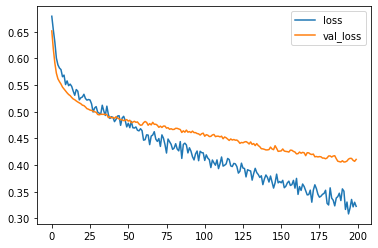

In [16]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

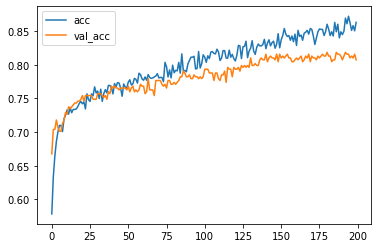

In [17]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [18]:
pred_test = model.predict(X_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[136,  27],
       [ 42, 153]], dtype=int64)

<h1> 1-2 以羅吉斯回歸實作 - 預測毛利率

In [19]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)

log_pred = log.predict(X_test)
print(log_pred)
print("==============================")
print(log.score(X_train, y_train))
# print(y_test)

[0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0
 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0
 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1
 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1
 1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1
 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1
 1 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1]
0.7132867132867133


In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, log_pred)
accuracy

0.6899441340782123

In [21]:
cm = confusion_matrix(y_test, log_pred)
cm

array([[112,  51],
       [ 60, 135]], dtype=int64)

<h2> 1-3 以 SVM 實作 - 預測毛利率

In [61]:
from sklearn.svm import SVC
clf = SVC(C = 1e5, kernel = 'linear')
clf.fit(X_train, y_train) 

SVC(C=100000.0, kernel='linear')

In [62]:
pred_clf = clf.predict(X_test)
print(pred_clf)
print("==============================")
print(clf.score(X_train, y_train))

[1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1
 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0
 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1]
0.5552447552447553


In [63]:
accuracy_SVM = accuracy_score(y_test, pred_clf)
accuracy_SVM

0.5

<h1>1.4 以 RandomForestClassifier 實作 毛利率預測

In [22]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest=RandomForestClassifier(n_estimators=100)


#Train the model using the training sets y_pred=clf.predict(X_test)
forest.fit(X_train, y_train)
print(forest.score(X_train, y_train))

1.0


In [23]:
from sklearn.metrics import accuracy_score
forest_pred=forest.predict(X_test)
print("Accuracy:",accuracy_score(y_test, forest_pred))

Accuracy: 0.8379888268156425


In [24]:
pred_test = np.round(forest_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[139,  24],
       [ 34, 161]], dtype=int64)

<h1> 1.5 以 naive_bayes 實作 毛利率預測

In [25]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb.score(X_train, y_train))

0.6734265734265734


In [26]:
nb_pred = nb.predict(X_test)
print("Accuracy:",accuracy_score(y_test, nb_pred))

Accuracy: 0.6843575418994413


In [27]:
pred_test = np.round(nb_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[107,  56],
       [ 57, 138]], dtype=int64)

<h1> 1.6 以 KNN 實作 毛利率預測

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))

0.893006993006993


In [29]:
knn_pred = knn.predict(X_test)
print("Accuracy:",accuracy_score(y_test, knn_pred))

Accuracy: 0.8268156424581006


In [30]:
pred_test = np.round(knn_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[142,  21],
       [ 41, 154]], dtype=int64)

<h2>初步測試預測"毛利率"結果:</h2>
<h4>1-1 DNN: 
    <h4>測試資料集準確度 0.8779; 訓練資料準確度 0.7836</h4>
<h4>1-2 Logistic:
    <h4>測試資料集準確度 0.7204; 訓練資料準確度 0.6648</h4>
<h4>1-3 SVM: 
    <h4>測試資料集準確度 0.5316; 訓練資料準確度 0.5068</h4>
<h4>1-4 RandomForestClassifier: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 0.8366</h4>
<h4>1-5 naive_bayes: 
    <h4>測試資料集準確度 0.5275; 訓練資料準確度 0.4930</h4>
<h4>1-6 KNN: 
    <h4>測試資料集準確度 0.6944; 訓練資料準確度 0.4676</h4>

<h3>目前"毛利率"表現最佳者為 RandomForestClassifier，DNN 其次

<h3>_____________________分隔_______________________

# 以財務數據預測 淨利率

<h2> 2-1 以 DNN 實作預測 淨利率

In [31]:
X_train, X_test, y1_train, y1_test = train_test_split(X_scaled, y1, test_size=0.2)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 13


In [32]:
# 建立TF模型 for 淨利
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model1.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 訓練模型
r1 = model1.fit(X_train, y1_train, validation_data=(X_test, y1_test), epochs=120)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model1.evaluate(X_train, y1_train))
print("Test score:", model1.evaluate(X_test, y1_test))

Epoch 1/120
45/45 [==============================] - 2s 18ms/step - loss: 0.6446 - accuracy: 0.6406 - val_loss: 0.5801 - val_accuracy: 0.8715
Epoch 2/120
45/45 [==============================] - 0s 7ms/step - loss: 0.5544 - accuracy: 0.8049 - val_loss: 0.4932 - val_accuracy: 0.9050
Epoch 3/120
45/45 [==============================] - 0s 6ms/step - loss: 0.4960 - accuracy: 0.8371 - val_loss: 0.4197 - val_accuracy: 0.9134
Epoch 4/120
45/45 [==============================] - 0s 7ms/step - loss: 0.4249 - accuracy: 0.8531 - val_loss: 0.3586 - val_accuracy: 0.9190
Epoch 5/120
45/45 [==============================] - 0s 7ms/step - loss: 0.3661 - accuracy: 0.8762 - val_loss: 0.3099 - val_accuracy: 0.9162
Epoch 6/120
45/45 [==============================] - 0s 7ms/step - loss: 0.3328 - accuracy: 0.8825 - val_loss: 0.2740 - val_accuracy: 0.9302
Epoch 7/120
45/45 [==============================] - 0s 6ms/step - loss: 0.2966 - accuracy: 0.9007 - val_loss: 0.2435 - val_accuracy: 0.9330
Epoch 8/120


Epoch 59/120
45/45 [==============================] - 0s 6ms/step - loss: 0.0986 - accuracy: 0.9580 - val_loss: 0.1186 - val_accuracy: 0.9525
Epoch 60/120
45/45 [==============================] - 0s 6ms/step - loss: 0.0913 - accuracy: 0.9713 - val_loss: 0.1198 - val_accuracy: 0.9497
Epoch 61/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0876 - accuracy: 0.9636 - val_loss: 0.1159 - val_accuracy: 0.9553
Epoch 62/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0970 - accuracy: 0.9601 - val_loss: 0.1208 - val_accuracy: 0.9525
Epoch 63/120
45/45 [==============================] - 0s 6ms/step - loss: 0.0922 - accuracy: 0.9636 - val_loss: 0.1193 - val_accuracy: 0.9525
Epoch 64/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0819 - accuracy: 0.9706 - val_loss: 0.1179 - val_accuracy: 0.9553
Epoch 65/120
45/45 [==============================] - 0s 6ms/step - loss: 0.0897 - accuracy: 0.9678 - val_loss: 0.1182 - val_accuracy: 0.9553
Epoch 

45/45 [==============================] - 0s 8ms/step - loss: 0.0802 - accuracy: 0.9699 - val_loss: 0.1140 - val_accuracy: 0.9553
Epoch 117/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0761 - accuracy: 0.9727 - val_loss: 0.1125 - val_accuracy: 0.9553
Epoch 118/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0689 - accuracy: 0.9713 - val_loss: 0.1157 - val_accuracy: 0.9525
Epoch 119/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0757 - accuracy: 0.9713 - val_loss: 0.1170 - val_accuracy: 0.9525
Epoch 120/120
45/45 [==============================] - 0s 3ms/step - loss: 0.0552 - accuracy: 0.9804
Train score: [0.055209334939718246, 0.9804195761680603]
12/12 [==============================] - 0s 3ms/step - loss: 0.1123 - accuracy: 0.9553
Test score: [0.11231399327516556, 0.9553072452545166]


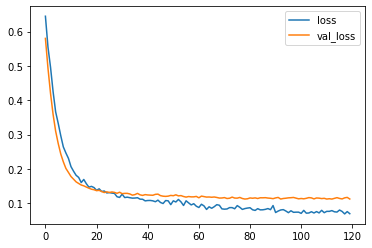

In [35]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r1.history['loss'], label='loss')
plt.plot(r1.history['val_loss'], label='val_loss')
plt.legend()

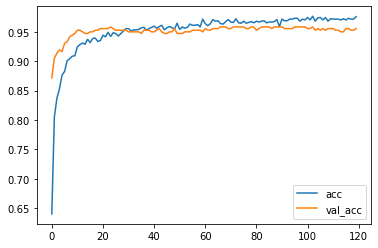

In [36]:
# 劃出準確性 accuracy 
plt.plot(r1.history['accuracy'], label='acc')
plt.plot(r1.history['val_accuracy'], label='val_acc')
plt.legend()

In [45]:
model.save('./net_profit_model.h5')

<h1> 2-2 用羅吉斯回歸實作 預測淨利率

In [37]:
from sklearn.linear_model import LogisticRegression
log1 = LogisticRegression()
log1.fit(X_train, y1_train)

pred1 = log1.predict(X_test)
print(pred1)
print("==============================")
print(log1.score(X_train, y1_train))
# print(y_test)

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0
 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1
 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1
 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1
 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1
 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1]
0.9643356643356643


In [38]:
accuracy1 = accuracy_score(y1_test, pred1)
accuracy1

0.9636871508379888

<h1> 2-3 以 SVM 實作 預測淨利率

In [64]:
from sklearn.svm import SVC
clf1 = SVC(C = 1e5, kernel = 'linear')
clf1.fit(X_train, y1_train) 
pred_clf1 = clf1.predict(X_test)
print(pred_clf1)
print("==============================")
print(clf1.score(X_train, y1_train))

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0
 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1
 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1
 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1
 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1
 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1]
0.9671328671328672


In [65]:
accuracy_SVM = accuracy_score(y1_test, pred_clf1)
accuracy_SVM

0.9553072625698324

<h1>2.4 以 RandomForestClassifier 實作 淨利率 預測

In [39]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest1=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest1.fit(X_train, y1_train)
print(forest1.score(X_train, y1_train))

1.0


In [40]:
from sklearn.metrics import accuracy_score
forest_pred1=forest1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, forest_pred1))

Accuracy: 0.9636871508379888


<h1> 2.5 以 naive_bayes 實作 淨利率 預測

In [41]:
from sklearn.naive_bayes import GaussianNB
nb1 = GaussianNB()
nb1.fit(X_train, y1_train)
print(nb1.score(X_train, y1_train))

0.8566433566433567


In [42]:
nb1_pred = nb1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, nb1_pred))

Accuracy: 0.8519553072625698


<h1> 2.6 以 KNN 實作 淨利率 預測

In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier()
knn1.fit(X_train, y1_train)
print(knn1.score(X_train, y1_train))

0.9300699300699301


In [44]:
knn1_pred = knn1.predict(X_test)
print("Accuracy:",accuracy_score(y1_test, knn1_pred))

Accuracy: 0.9050279329608939


<h3>初步測試預測"淨利率"結果:</h3>
<h4>1-1 DNN: 
    <h4>測試資料集準確度 0.8237; 訓練資料準確度 0.7753</h4>
<h4>1-2 Logistic:
    <h4>測試資料集準確度 0.7428 ; 訓練資料準確度 0.7726</h4>
<h4>1-3 SVM: 
    <h4>測試資料集準確度 0.7479; 訓練資料準確度 0.7239</h4>
<h4>1-4 RandomForestClassifier: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 0.7915</h4>
<h4>1-5 naive_bayes: 
    <h4>測試資料集準確度 0.7246; 訓練資料準確度 0.7211</h4>
<h4>1-6 KNN: 
    <h4>測試資料集準確度 0.8655; 訓練資料準確度 0.8169</h4>

<h3>目前 "淨利率預測" 各演算法表現相近，最佳者為 KNN ，RandomForestClassifier 其次

<h3>_____________________分隔_______________________

# 以財務數據預測 ROE

In [46]:
X1_train, X1_test, y2_train, y2_test = train_test_split(X1_scaled, y2, test_size=0.2)
N, D = X1_train.shape
print ("N:", N, "D:", D)

N: 1430 D: 13


<h2> 3-1 以 DNN 實作預測 ROE

In [47]:
# 建立TF模型 for 淨利
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
lr = 0.0003
model3.compile(tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 訓練模型
r3 = model3.fit(X1_train, y2_train, validation_data=(X1_test, y2_test), epochs=120)

# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model3.evaluate(X1_train, y2_train))
print("Test score:", model3.evaluate(X1_test, y2_test))

Epoch 1/120
45/45 [==============================] - 2s 11ms/step - loss: 0.7206 - accuracy: 0.5070 - val_loss: 0.6629 - val_accuracy: 0.4888
Epoch 2/120
45/45 [==============================] - 0s 6ms/step - loss: 0.6306 - accuracy: 0.6203 - val_loss: 0.5807 - val_accuracy: 0.7263
Epoch 3/120
45/45 [==============================] - 0s 7ms/step - loss: 0.5695 - accuracy: 0.7210 - val_loss: 0.5175 - val_accuracy: 0.8184
Epoch 4/120
45/45 [==============================] - 0s 6ms/step - loss: 0.5100 - accuracy: 0.8091 - val_loss: 0.4584 - val_accuracy: 0.8799
Epoch 5/120
45/45 [==============================] - 0s 7ms/step - loss: 0.4556 - accuracy: 0.8497 - val_loss: 0.4033 - val_accuracy: 0.9022
Epoch 6/120
45/45 [==============================] - 0s 8ms/step - loss: 0.3987 - accuracy: 0.8825 - val_loss: 0.3519 - val_accuracy: 0.9162
Epoch 7/120
45/45 [==============================] - 0s 8ms/step - loss: 0.3568 - accuracy: 0.8888 - val_loss: 0.3068 - val_accuracy: 0.9358
Epoch 8/120


Epoch 59/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9874 - val_loss: 0.0454 - val_accuracy: 0.9777
Epoch 60/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0408 - accuracy: 0.9860 - val_loss: 0.0473 - val_accuracy: 0.9749
Epoch 61/120
45/45 [==============================] - 0s 6ms/step - loss: 0.0437 - accuracy: 0.9846 - val_loss: 0.0472 - val_accuracy: 0.9777
Epoch 62/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0400 - accuracy: 0.9860 - val_loss: 0.0459 - val_accuracy: 0.9777
Epoch 63/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0438 - accuracy: 0.9825 - val_loss: 0.0454 - val_accuracy: 0.9749
Epoch 64/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0396 - accuracy: 0.9846 - val_loss: 0.0456 - val_accuracy: 0.9804
Epoch 65/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9923 - val_loss: 0.0442 - val_accuracy: 0.9804
Epoch 

45/45 [==============================] - 0s 8ms/step - loss: 0.0202 - accuracy: 0.9923 - val_loss: 0.0414 - val_accuracy: 0.9832
Epoch 117/120
45/45 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9951 - val_loss: 0.0416 - val_accuracy: 0.9832
Epoch 118/120
45/45 [==============================] - 0s 8ms/step - loss: 0.0287 - accuracy: 0.9881 - val_loss: 0.0405 - val_accuracy: 0.9832
Epoch 119/120
45/45 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9923 - val_loss: 0.0386 - val_accuracy: 0.9860
Epoch 120/120
45/45 [==============================] - 0s 4ms/step - loss: 0.0090 - accuracy: 1.0000
Train score: [0.009017647244036198, 1.0]
12/12 [==============================] - 0s 3ms/step - loss: 0.0397 - accuracy: 0.9860
Test score: [0.039725594222545624, 0.9860334992408752]


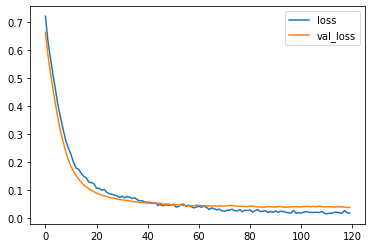

In [50]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r3.history['loss'], label='loss')
plt.plot(r3.history['val_loss'], label='val_loss')
plt.legend()

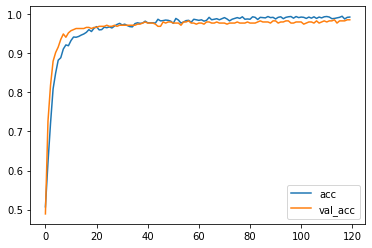

In [51]:
# 劃出準確性 accuracy 
plt.plot(r3.history['accuracy'], label='acc')
plt.plot(r3.history['val_accuracy'], label='val_acc')
plt.legend()

In [52]:
pred_test = model3.predict(X1_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y2_test, pred_test)
cm

array([[150,   3],
       [  2, 203]], dtype=int64)

In [58]:
model3.save('./ROE_model.h5')

<h1> 3-2 用羅吉斯回歸實作 預測 ROE

In [53]:
from sklearn.linear_model import LogisticRegression
log3 = LogisticRegression()
log3.fit(X1_train, y2_train)

pred3 = log3.predict(X1_test)
print(pred3)
print("==============================")
print(log3.score(X1_train, y2_train))
# print(y_test)

[0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0
 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1
 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0
 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0
 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1
 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1
 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0
 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1]
0.990909090909091


In [54]:
accuracy3 = accuracy_score(y2_test, pred3)
accuracy3

0.9804469273743017

<h1> 3-3 以 SVM 實作 預測 ROE

In [66]:
from sklearn.svm import SVC
clf3 = SVC(C = 1e5, kernel = 'linear')
clf3.fit(X1_train, y2_train) 
pred_clf3 = clf3.predict(X1_test)
print(pred_clf3)
print("==============================")
print(clf3.score(X1_train, y2_train))

[0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0
 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1
 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0
 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0
 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1
 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1
 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0
 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1]
1.0


In [67]:
accuracy_SVM = accuracy_score(y2_test, pred_clf3)
accuracy_SVM

0.9916201117318436

<h1>3.4 以 RandomForestClassifier 實作 ROE 預測

In [55]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest3=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
forest3.fit(X1_train, y2_train)
print(forest3.score(X1_train, y2_train))

1.0


In [56]:
from sklearn.metrics import accuracy_score
forest_pred3 = forest3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, forest_pred3))

Accuracy: 1.0


<h1> 3.5 以 naive_bayes 實作 ROE 預測

In [57]:
from sklearn.naive_bayes import GaussianNB
nb3 = GaussianNB()
nb3.fit(X1_train, y2_train)
print(nb3.score(X1_train, y2_train))

0.7972027972027972


In [58]:
nb3_pred = nb3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, nb3_pred))

Accuracy: 0.8296089385474861


<h1> 3.6 以 KNN 實作 ROE 預測

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn3 = KNeighborsClassifier()
knn3.fit(X1_train, y2_train)
print(knn3.score(X1_train, y2_train))

0.9314685314685315


In [60]:
knn3_pred = knn3.predict(X1_test)
print("Accuracy:",accuracy_score(y2_test, knn3_pred))

Accuracy: 0.9078212290502793


<h3>初步測試預測"ROA"結果:</h3>
<h4>1-1 DNN: 
    <h4>測試資料集準確度 0.9979; 訓練資料準確度 0.9915</h4>
<h4>1-2 Logistic:
    <h4>測試資料集準確度 0.9908 ; 訓練資料準確度 0.9887</h4>
<h4>1-3 SVM: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 0.9972</h4>
<h4>1-4 RandomForestClassifier: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 1.0000</h4>
<h4>1-5 naive_bayes: 
    <h4>測試資料集準確度 0.8654; 訓練資料準確度 0.8676</h4>
<h4>1-6 KNN: 
    <h4>測試資料集準確度 0.9323; 訓練資料準確度 0.8789</h4>

<h3>___________終止線_______________

<h1>加入 運費指標 (BDI 與 航空燃油) 

<h2>資料前處理

In [84]:

#建立與 MySQL 的連結
# class mysql_engine():
#  def __init__(self,db):
#   self.user='root'
#   self.passwd='ian1991'
#   self.host='localhost'
#   self.port = '3306'
#   self.db_name= db
#   self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

# #設定讀取 MySQL 中的資料表並轉為 DataFrame 的功能
# def get_data1(sql):
#  pg_enine=mysql_engine1()
#  try:
#   with pg_enine.engine.connect() as con, con.begin():
#    df=pd.read_sql(sql,con)# 獲取資料
#   con.close()
#  except:
#   df=None
#  return df

In [102]:
env_factor = get_data("""SELECT * FROM env_factor_new;""",'tfb103d_project')
env_factor.head(10)

,data_date,BDI,BCI,BPI,N1NG,avgas_cpc,avgas_fpg,Dubai,WTI_future,WTI_now,...,people_fully_vaccinated_per_hundred_USA,people_fully_vaccinated_per_hundred_OWID_EUR,people_fully_vaccinated_per_hundred_GBR,people_fully_vaccinated_per_hundred_FRA,people_fully_vaccinated_per_hundred_JPN,people_fully_vaccinated_per_hundred_CHN,people_fully_vaccinated_per_hundred_TWN,people_fully_vaccinated_per_hundred_OWID_WRL,people_fully_vaccinated_per_hundred_HKG,people_fully_vaccinated_per_hundred_SGP
0,20182,1818.56,2880.00,1828.22,3.94,0.65,0.65,78.83,75.69,75.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20183,1609.62,2865.92,1524.85,2.89,0.60,0.60,73.92,69.47,69.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20184,1340.21,1960.14,1528.79,3.71,0.62,0.62,64.96,57.40,57.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20191,799.00,950.23,879.00,2.85,0.51,0.52,63.88,55.19,55.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20192,1010.15,1360.31,1195.62,2.48,0.56,0.56,67.03,59.65,59.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20193,2049.54,3899.77,2027.46,2.32,0.53,0.53,60.61,56.10,55.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20194,1486.21,2687.36,1407.57,2.40,0.53,0.53,62.06,57.47,57.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20201,598.46,694.00,798.31,1.82,0.51,0.50,50.59,46.46,45.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,20202,777.92,1125.31,818.85,1.74,0.24,0.24,33.59,29.42,29.23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,20203,1518.31,2529.46,1459.23,2.18,0.32,0.32,42.55,40.76,40.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4>因為環境因素與財務資料時間有差異，先以 inner join merge 合併

In [103]:
#取得需要的特徵
dF = company_factor[['stock_code',
                    'data_date',
                    'net_profit_rate', #稅後淨利率
                    'operating_gross_rate', #營業毛利率
                    'current_rate', #流動比率
                    'quick_rate',  #速動比率
                    'debt_rate',  #負債比率
                    'receivables_turnover_rate', #應收帳款週轉率
                    'inventory_turnover_rate',  #存貨週轉率
                    'cash_reinvest_rate', #現金再投資比率
                    'avg_director_rate', #董監事持股比利
                    'avg_director_pledge_rate', #董監事質押比利
                    'foreign_rate_bys', #外資持股比例
                    'over1000_rate_bys', # >1000張大股東持股比率
                    'under400_rate_bys', # <400張股東持股比率
                    'avg_board_bys' #平均持股張數
                      ]].copy() 

In [104]:
# dF = financial_statements[['stock_report_date','net_profit_rate','operating_gross_rate','current_rate', 'quick_rate', 'debt_rate', 'receivables_turnover_rate', 'inventory_turnover_rate', 'cash_reinvest_rate']]
dE = env_factor[['data_date','BDI','avgas_cpc']]
data_add1 = pd.merge(dF,dE,on='data_date',how="inner")

In [105]:
data_add1.isnull().sum()

stock_code                    0
data_date                     0
net_profit_rate              28
operating_gross_rate         28
current_rate                 14
quick_rate                   14
debt_rate                    14
receivables_turnover_rate    26
inventory_turnover_rate      70
cash_reinvest_rate           15
avg_director_rate             0
avg_director_pledge_rate      0
foreign_rate_bys              0
over1000_rate_bys            63
under400_rate_bys            63
avg_board_bys                63
BDI                           0
avgas_cpc                     0
dtype: int64

In [106]:
data_add_nona = data_add1.copy()
#以 0 填補
data_add_nona['inventory_turnover_rate'].fillna(0, inplace = True)


#刪除
data_add_nona = data_add_nona.dropna()


In [107]:
data_add_nona.isnull().sum()

stock_code                   0
data_date                    0
net_profit_rate              0
operating_gross_rate         0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
inventory_turnover_rate      0
cash_reinvest_rate           0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
BDI                          0
avgas_cpc                    0
dtype: int64